# CS5850 Final Project

Jack Jones, A02210852

Paige MacGregor, A02360473

Jakob Johnson, A02329130

Andrew Ward, A02257489

Due Date: April 26, 2024 (11:59 PM)


#### Purpose:

The purpose of this project is to practice the concepts we learned from lecture and apply data analysis tools and algorithms to an application.

In [1]:
# Imports needed for this notebook

import pandas as pd
import os
import csv
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import re

Part 1 - Data Collection

In [ ]:
# To run this script, the file boardgames_ranks.csv is required.
# This script fetches board game details from the BGG XML 2 API 100 games at a time every 5 seconds.
# It will take roughly 5 hours to run.
import requests as req
import pandas as pd
import xml.etree.ElementTree as ET
import time

game_ranks = pd.read_csv('./boardgames_ranks.csv')
list_ids = game_ranks['id'].to_list()

def get_next_ids(start, length):
    ids = ''
    for id in list_ids[start : start + length]:
        ids += f"{id},"
    ids = ids[:-1]
    return ids

columns = ['id', 'name', 'type', 'description', 'year_published', 'min_players', 'max_players',
            'playing_time', 'min_age', 'categories', 'mechanics', 'families', 'publishers']
def parse_xml_to_csv(root, csv_file):
    all_games = pd.DataFrame(columns=columns)
    # extract each item returned from req
    for item in root.findall('item'):
        id = item.get('id')
        # handle primary name
        name = None
        for n in item.findall('name'):
            if n.get('type') == 'primary':
                name = n.get('value')
        if name == None:
            name = item.get('name')

        type = item.get('type')
        if item.find('description') == None:
            description = ''
        else:
            description = item.find('description').text
        if item.find('yearpublished') == None:
            year_published = ''
        else:
            year_published = item.find('yearpublished').attrib['value']
        if item.find('minplayers') == None:
            min_players = 1
        else:
            min_players = item.find('minplayers').attrib['value']
        if item.find('maxplayers') == None:
            max_players = ''
        else:
            max_players = item.find('maxplayers').attrib['value']
        if item.find('playingtime') == None:
            playing_time = ''
        else:
            playing_time = item.find('playingtime').attrib['value']
        if item.find('minage') == None:
            min_age = 8
        else:
            min_age = item.find('minage').attrib['value']

        # handle all link tags
        links = item.findall('link')
        categories = []
        mechanics = []
        families = []
        publishers = []

        for link in links:
            if link.get('type') == 'boardgamecategory':
                categories.append(link.get('value'))
            elif link.get('type') == 'boardgamemechanic':
                mechanics.append(link.get('value'))
            elif link.get('type') == 'boardgamefamily':
                families.append(link.get('value'))
            elif link.get('type') == 'boardgamepublisher':
                publishers.append(link.get('value'))
        all_games.loc[len(all_games)] = [id, name, type, description, year_published, min_players, max_players,
                                        playing_time, min_age, categories, mechanics, families, publishers]
    all_games.to_csv(csv_file, mode='a', index=False, header=False)
    del(all_games)

chunk_size = 100
i = 0

while i < len(list_ids):
    if i + chunk_size > len(list_ids):
        chunk_size = len(list_ids) - i
    timeouts = 0
    pre_req = time.time()
    while timeouts < 10:
        try:
            xml_data = req.get('https://boardgamegeek.com/xmlapi2/thing?id=' + get_next_ids(i, chunk_size), timeout=10)
            break
        except req.exceptions.Timeout:
            print(f"Timed out, trying again...")
            timeouts += 1
            continue
    print(f'Request took {time.time()-pre_req}s, with {timeouts} timeouts.')

    start_time = time.time()
    print(f"status: {xml_data.status_code}")
    root = ET.fromstring(xml_data.text)
    pre_parse = time.time()
    parse_xml_to_csv(root, './game_details.csv')
    print(f'Parse took {time.time()-pre_parse}s')
    print(f"{i} / {len(list_ids)} : {i/len(list_ids) * 100}%\n - - - - - - -")
    i = i + chunk_size
    while time.time() - start_time <= 5:
        pass

Request took 1.2935962677001953s, with 0 timeouts.
status: 200
Parse took 0.24174094200134277s
0 / 152955 : 0.0%
 - - - - - - -
Request took 1.1166605949401855s, with 0 timeouts.
status: 200
Parse took 0.20041275024414062s
100 / 152955 : 0.06537870615540518%
 - - - - - - -
Request took 1.1958506107330322s, with 0 timeouts.
status: 200
Parse took 0.22695589065551758s
200 / 152955 : 0.13075741231081037%
 - - - - - - -
Request took 1.329519271850586s, with 0 timeouts.
status: 200
Parse took 0.20154285430908203s
300 / 152955 : 0.19613611846621554%
 - - - - - - -
Request took 1.3813672065734863s, with 0 timeouts.
status: 200
Parse took 0.20256257057189941s
400 / 152955 : 0.26151482462162073%
 - - - - - - -
Request took 1.2056641578674316s, with 0 timeouts.
status: 200
Parse took 0.18995332717895508s
500 / 152955 : 0.32689353077702593%
 - - - - - - -
Request took 1.126722812652588s, with 0 timeouts.
status: 200
Parse took 0.2089834213256836s
600 / 152955 : 0.3922722369324311%
 - - - - - - -


KeyboardInterrupt: 

In [2]:
# The above script errored out a few times so I had to start it again where it was at. Some ids were missed, and some were duplicated.
# so this script helps fixes those problems by removing duplicates and outputting a list of ids that weren't added to the game_details.
import requests as req
import pandas as pd

game_ranks = pd.read_csv('./boardgames_ranks.csv')
list_ids = game_ranks['id'].to_list()

game_details = pd.read_csv('./game_details.csv')

missing_ids = []
for id in list_ids:
    if not id in game_details['id'].values:
        missing_ids.append(id)

game_details = game_details.drop_duplicates(subset='id')

print(missing_ids)

game_details.to_csv('./game_details_no_duplicates.csv', index=False)

KeyError: 'id'

Part 2 - Initial Data Analysis

In [5]:
# Most common words for different board game review ratings

# Load the data
file_path = 'random_10k_reviews.csv'
data = pd.read_csv(file_path)

# Define the ranking groups and labels
bins = [0, 2.5, 5, 7.5, 10]
labels = ['1-2.5', '2.5-5', '5-7.5', '7.5-10']
data['group'] = pd.cut(data['rating'], bins=bins, labels=labels, right=False)

# Calculate total count of reviews with no comment for each group
no_comment_counts = data[data['comment'].isnull()].groupby('group').size()

# Drop rows where 'comment' is NaN for further analysis
data_cleaned = data.dropna(subset=['comment'])

# Function to extract the most common words
def get_top_words(data, n_top_words=5):
    vectorizer = CountVectorizer(stop_words='english')
    word_count_matrix = vectorizer.fit_transform(data['comment'])
    sum_words = word_count_matrix.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n_top_words]

# Group the cleaned data and apply the function to find common words
grouped_data_cleaned = data_cleaned.groupby('group')
common_words_per_group = {label: get_top_words(group_data) for label, group_data in grouped_data_cleaned}
comment_counts = grouped_data_cleaned.size()

for label in labels:
    print(f"Group {label}:")
    print(f"  Top 5 Words: {common_words_per_group.get(label, 'No comments')}")
    print(f"  Number of Comments: {comment_counts.get(label, 0)}")
    print(f"  Number of No-Comments: {no_comment_counts.get(label, 0)}")
    print()

Group 1-2.5:
  Top 5 Words: [('game', 48), ('play', 18), ('games', 12), ('just', 12), ('players', 10)]
  Number of Comments: 37
  Number of No-Comments: 73

Group 2.5-5:
  Top 5 Words: [('game', 154), ('games', 46), ('play', 40), ('just', 38), ('like', 28)]
  Number of Comments: 144
  Number of No-Comments: 387

Group 5-7.5:
  Top 5 Words: [('game', 762), ('play', 273), ('fun', 192), ('like', 183), ('good', 135)]
  Number of Comments: 921
  Number of No-Comments: 4135

Group 7.5-10:
  Top 5 Words: [('game', 604), ('play', 178), ('like', 133), ('fun', 128), ('really', 123)]
  Number of Comments: 629
  Number of No-Comments: 3187



In [6]:
# Word count for different board game review ratings bins

# Load the data
file_path = 'random_10k_reviews.csv'
data = pd.read_csv(file_path)

# Define the ranking groups and labels
bins = [0, 2.5, 5, 7.5, 10]
labels = ['1-2.5', '2.5-5', '5-7.5', '7.5-10']
data['group'] = pd.cut(data['rating'], bins=bins, labels=labels, right=False)

# Remove rows without comments for word count analysis
data_cleaned = data.dropna(subset=['comment'])

# Calculate word count for each comment
data_cleaned['word_count'] = data_cleaned['comment'].apply(lambda x: len(x.split()))

# Calculate average word count for each group
average_word_count = data_cleaned.groupby('group')['word_count'].mean()

print(average_word_count)

group
1-2.5     56.891892
2.5-5     51.437500
5-7.5     34.470141
7.5-10    38.027027
Name: word_count, dtype: float64


<ipython-input-6-55ff081a36b9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['word_count'] = data_cleaned['comment'].apply(lambda x: len(x.split()))


In [10]:
# generate master list of mechanics
import ast
df = pd.read_csv('game_details_no_duplicates.csv')
unique_mechanics = set()
df['mechanics'] = df['mechanics'].apply(ast.literal_eval)
for mechanics_list in df['mechanics']:
    unique_mechanics.update(mechanics_list)
unique_mechanics_df = pd.DataFrame(unique_mechanics, columns=['Mechanic'])
unique_mechanics_df.to_csv('unique_mechanics.csv', index=False)

num_items = len(unique_mechanics_df)
print("Number of mechanics in the CSV:", num_items)

Number of mechanics in the CSV: 192


In [11]:
# Popular mechanics by country, general stats about the mechanics

mechanism_counts = {}
for mechanics_list in df['mechanics']:
    for mechanism in mechanics_list:
        mechanism_counts[mechanism] = mechanism_counts.get(mechanism, 0) + 1

mechanism_counts_df = pd.DataFrame(list(mechanism_counts.items()), columns=['Mechanic', 'Count'])
most_common_mechanisms = mechanism_counts_df.sort_values(by='Count', ascending=False)

print("Occurrence of all game mechanisms:")
print(most_common_mechanisms)

Occurrence of all game mechanisms:
                    Mechanic  Count
39              Dice Rolling  39360
0            Hand Management  21371
142     Roll / Spin and Move  17341
14            Set Collection  15948
16    Variable Player Powers  15946
..                       ...    ...
136   Closed Economy Auction     23
122           Neighbor Scope     21
191       Auction: Dexterity     18
170     Auction Compensation      9
182  Auction: Dutch Priority      5

[192 rows x 2 columns]


In [12]:
# distribution of game mechanics - see if some tend to go with higher rated games vs lower rated ones

# Insert game rating into the game_details_no_duplicates

file_path1 = 'game_details_no_duplicates.csv'
data1 = pd.read_csv(file_path1)

file_path2 = 'boardgames_ranks.csv'
data2 = pd.read_csv(file_path2)

# data2.loc[data2['id'] == 220308]['group']

# Merge the data sets
merged = pd.merge(data1, data2, on="id", how="left")

merged = merged.sort_values(by="id")

merged = merged.reset_index(drop=True)

# Draw a graph :D

merged['mechanics']

#merged

0         ['Alliances', 'Area Majority / Influence', 'Au...
1                                          ['Trick-taking']
2         ['Area Majority / Influence', 'Hand Management...
3         ['Action Points', 'Area Majority / Influence',...
4         ['Hand Management', 'Investment', 'Market', 'S...
                                ...                        
152920                                     ['Dice Rolling']
152921               ['Scenario / Mission / Campaign Game']
152922                 ['Dice Rolling', 'Paper-and-Pencil']
152923                                     ['Dice Rolling']
152924                                                   []
Name: mechanics, Length: 152925, dtype: object

In [13]:
# Make a dictionary holding all of the ratings for each mechanic

mechanicsDict = {}
for index, row in merged.iterrows():
  rating = row['average']
  if rating == 0:
    continue
  mechanics = row['mechanics']
  mechanics = re.split('\", |\', ', mechanics)
  for i in range(len(mechanics)):
    mechanics[i] = mechanics[i].replace('\'', "")
    mechanics[i] = mechanics[i].replace('\"', "")
  mechanics[0] = mechanics[0][1:]
  mechanics[-1] = mechanics[-1][:-1]

  for mechanic in mechanics:
    if mechanic == '':
      continue


    if mechanic in mechanicsDict:
      mechanicsDict[mechanic].append(rating)

    else:
      mechanicsDict[mechanic] = [rating]

mechanicsDict

{'Alliances': [7.59757,
  6.92422,
  7.59032,
  6.53372,
  5.47943,
  5.99912,
  6.02901,
  6.68302,
  5.56273,
  5.82692,
  5.04545,
  5.89286,
  5.25303,
  5.81818,
  6.83333,
  7.5,
  6.14486,
  5.9875,
  5.65185,
  7.53027,
  6.9,
  6.02508,
  7.52398,
  7.53804,
  7.05289,
  6.26027,
  7.07495,
  6.56238,
  7.5004,
  7.88449,
  7.75402,
  6.76987,
  7.77748,
  6.76568,
  7.33333,
  7.53125,
  6.67143,
  8.4649,
  7.01665,
  8.13662,
  7.34625,
  7.7712,
  7.78147,
  6.41567,
  7.95343,
  7.81312,
  6.88221,
  7.75333,
  9.16667,
  7.29412,
  8.0,
  8.5,
  6.13958,
  8.41481,
  8.10294,
  7.66667,
  8.16415,
  10.0,
  7.49429,
  7.69091,
  7.99733,
  9.2,
  8.0625,
  6.66667,
  3.65,
  10.0,
  9.33333,
  8.11034,
  6.41051,
  8.41667,
  9.0,
  7.38197,
  8.37108,
  8.20851,
  7.0,
  7.7561,
  4.79327,
  7.81544,
  5.21104,
  9.0,
  7.37176,
  6.0,
  5.40465,
  9.66667,
  9.0,
  6.07486,
  9.0,
  5.0,
  8.5,
  6.58788,
  4.79167,
  7.4,
  5.61735,
  7.92857,
  7.71429,
  7.44444,
  

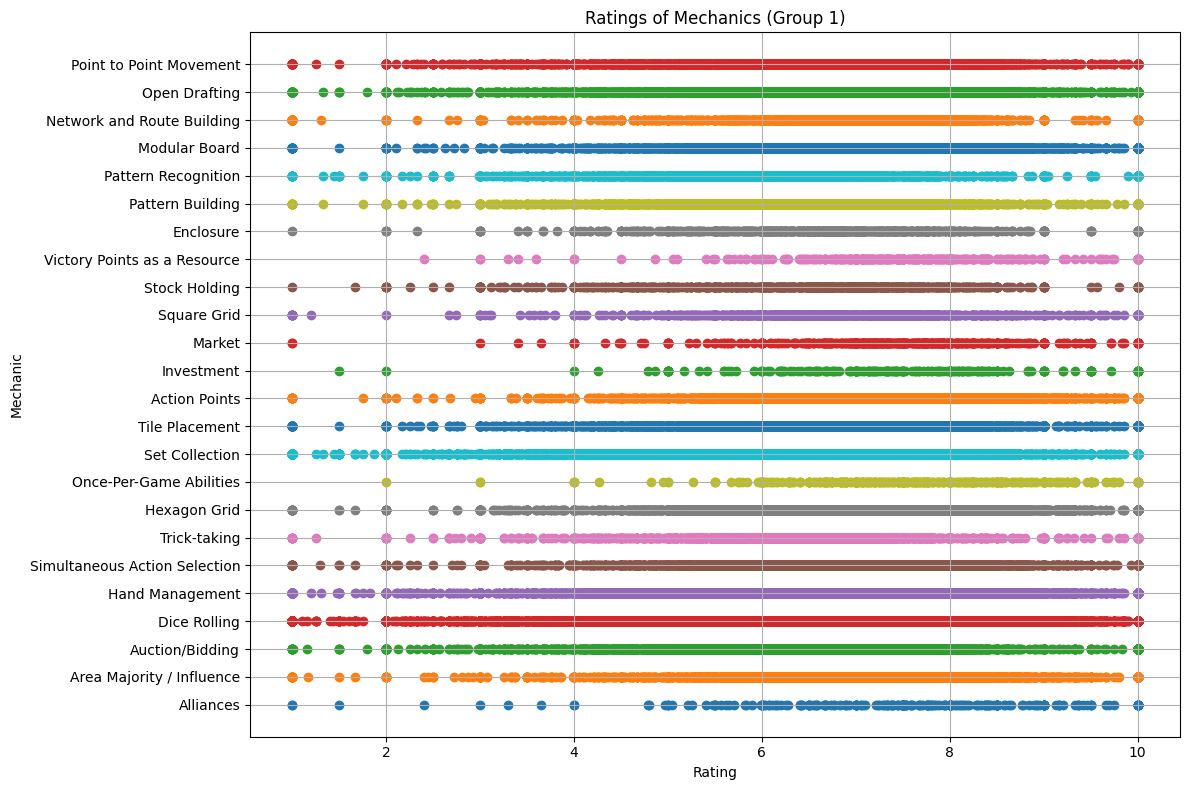

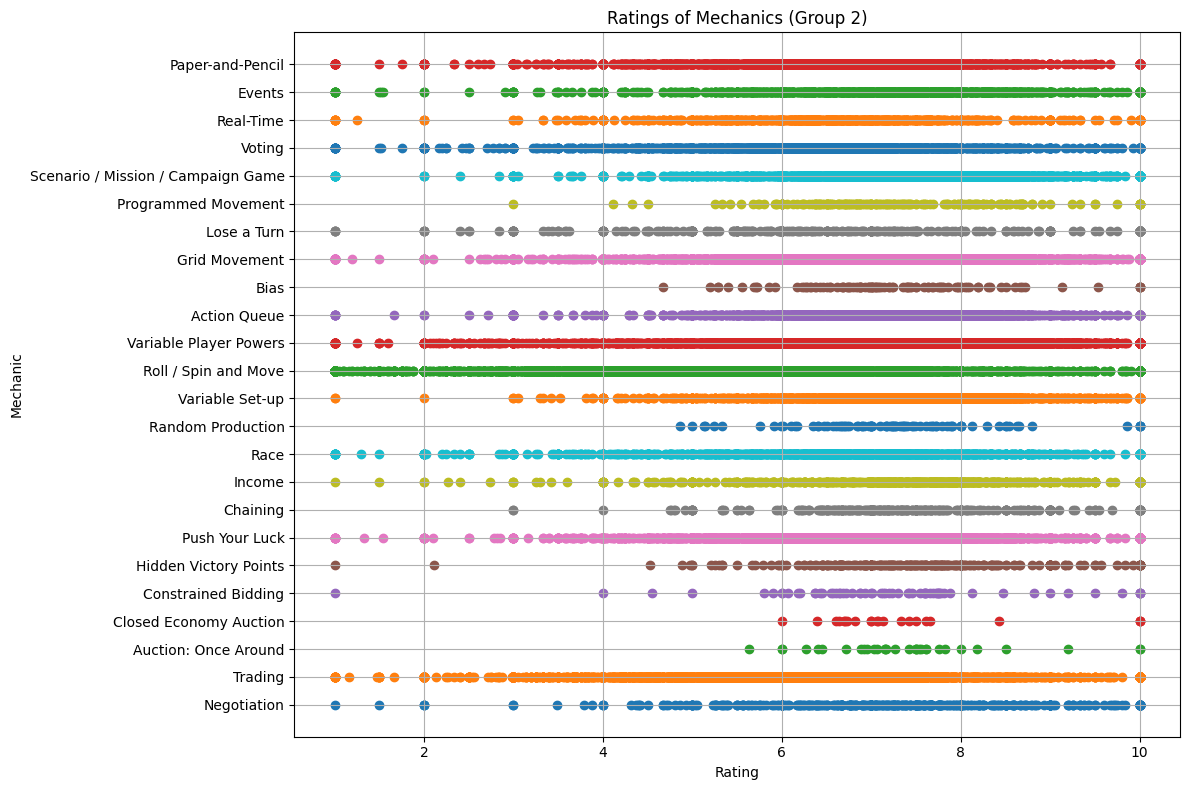

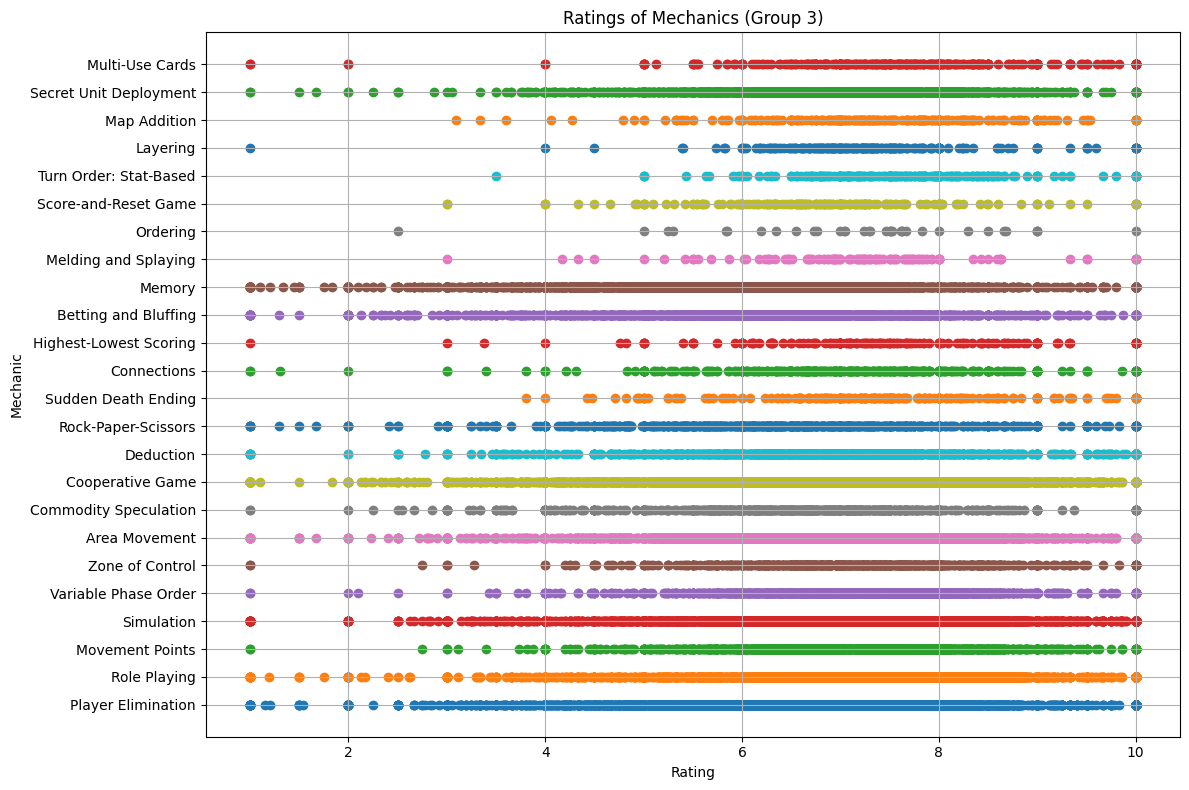

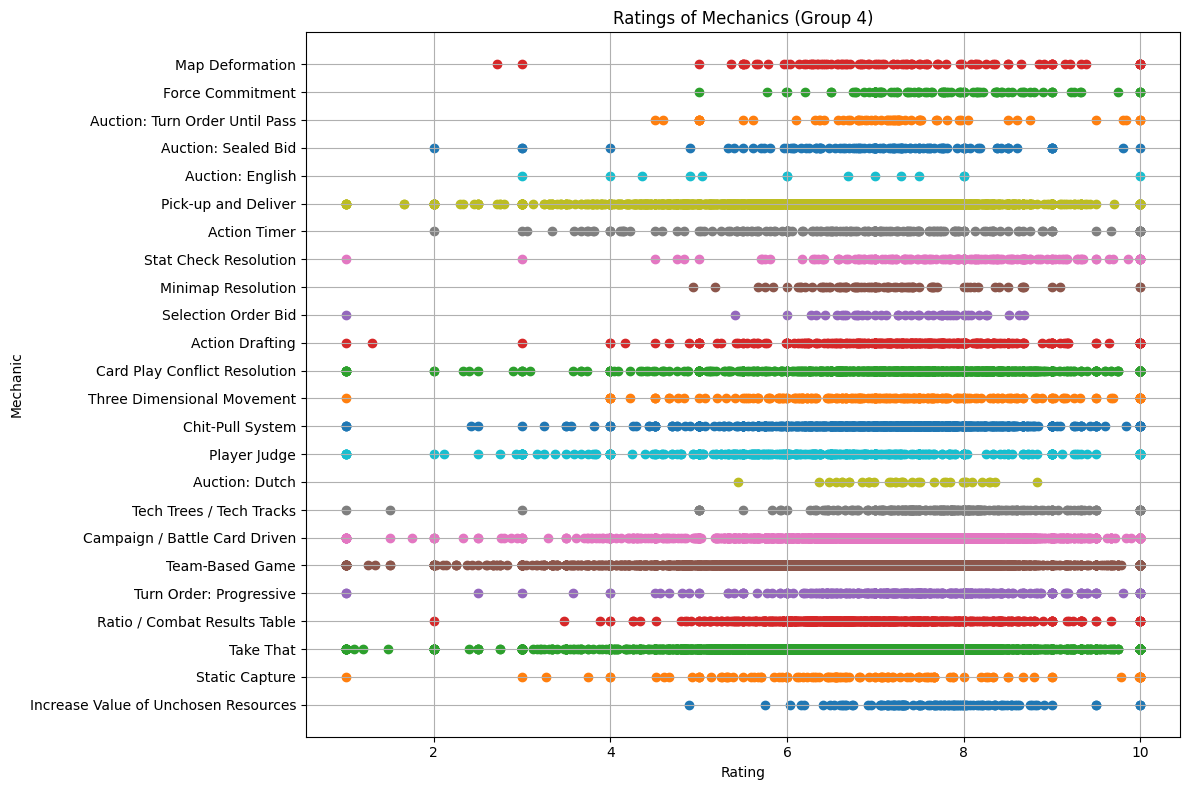

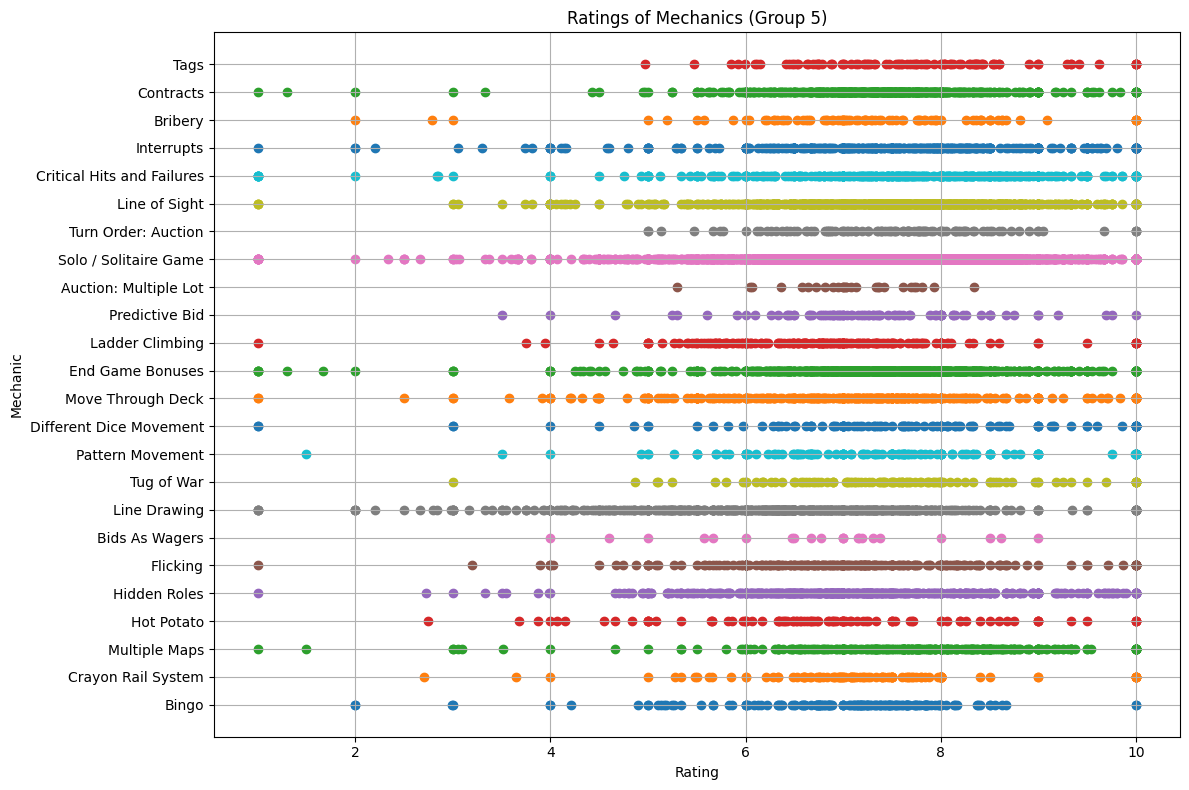

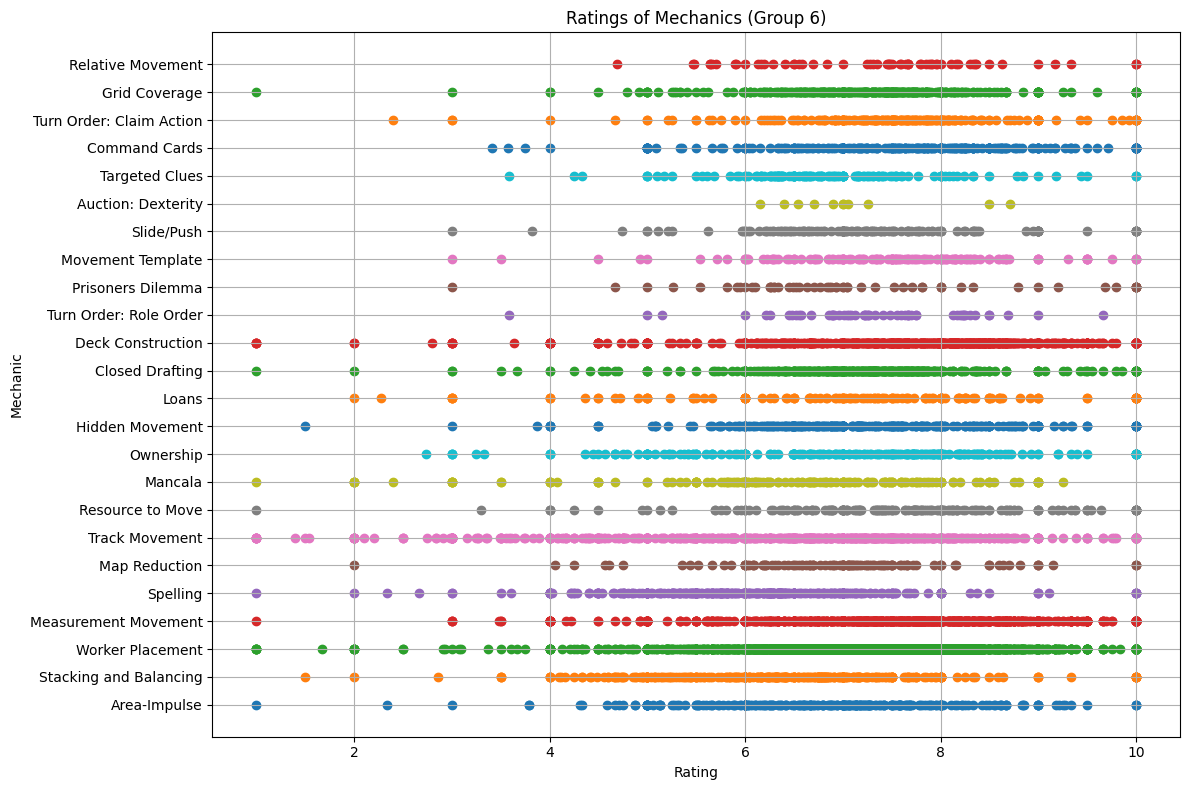

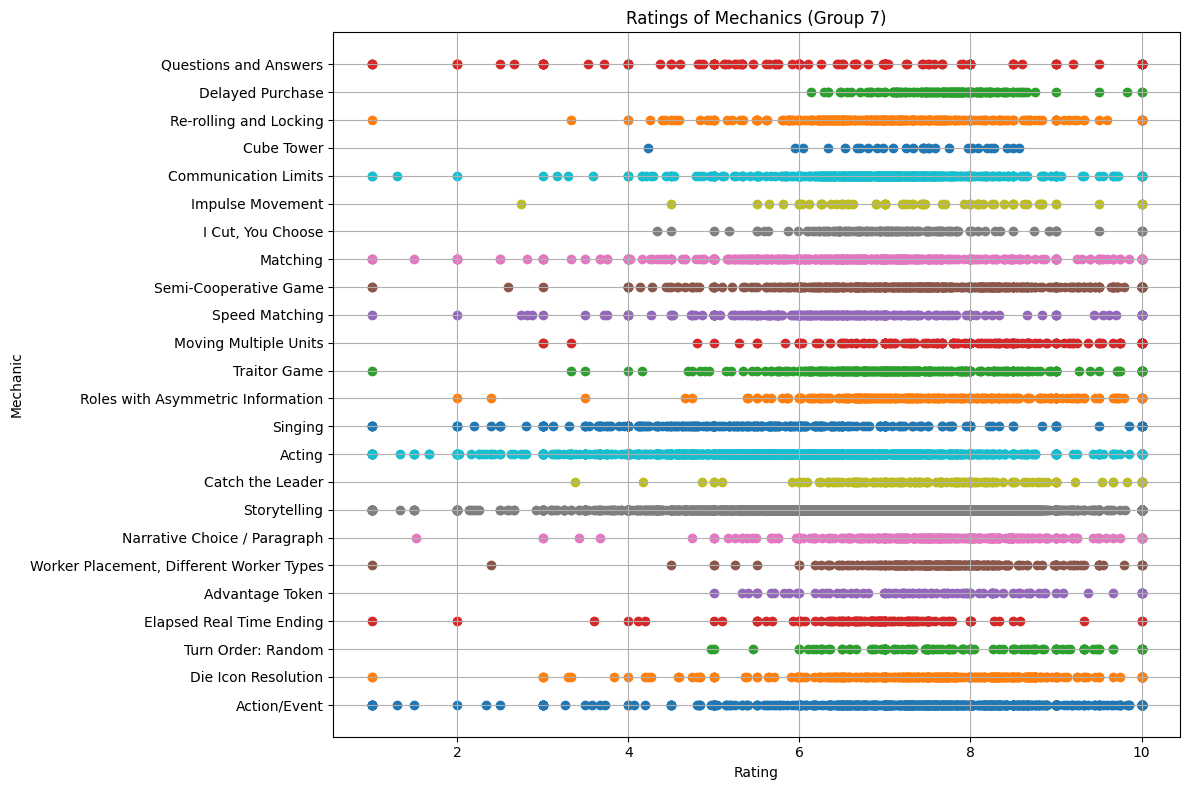

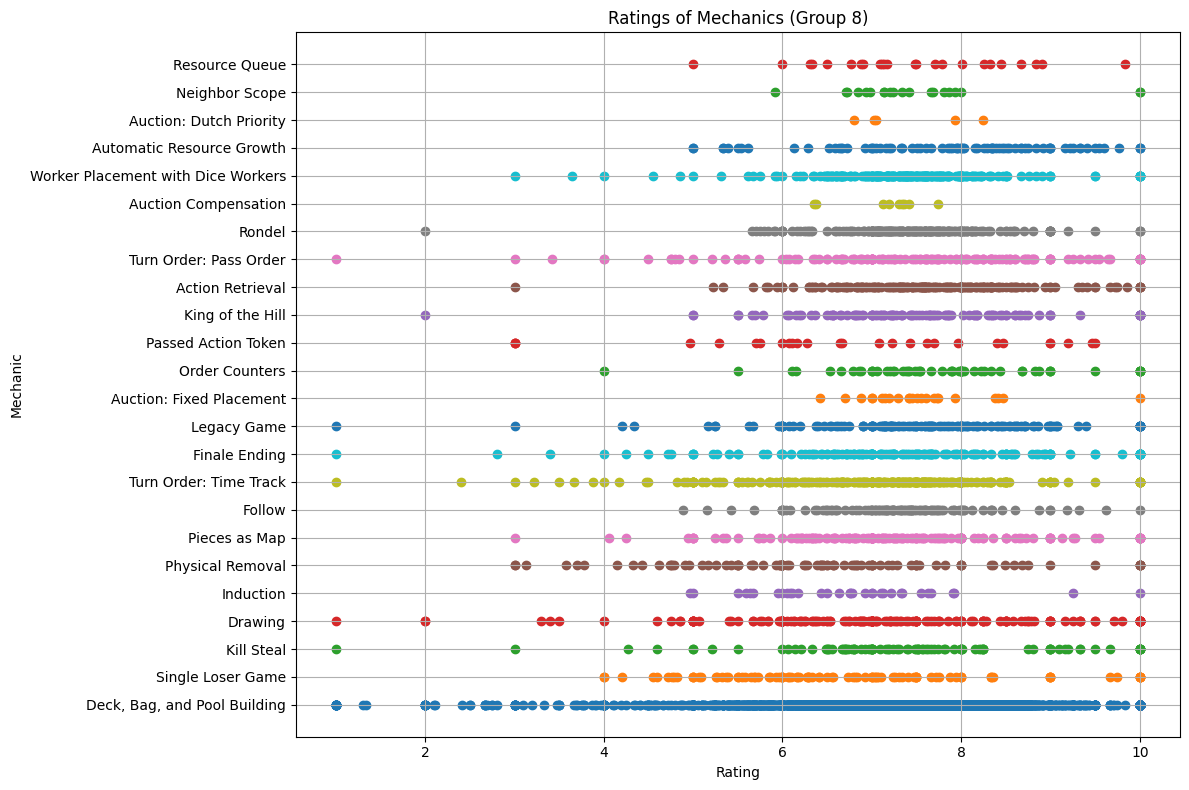

In [ ]:
mechanics = list(mechanicsDict.keys())
ratings = [rating for sublist in mechanicsDict.values() for rating in sublist]

mechanics_groups = [list(mechanicsDict.keys())[i:i + len(mechanicsDict)// 8] for i in range(0, len(mechanicsDict), len(mechanicsDict)// 8)]


# Create scatter plots for each group
for i, group in enumerate(mechanics_groups):
    plt.figure(figsize=(12, 8))
    for mechanic in group:
        plt.scatter( mechanicsDict[mechanic], [mechanic] * len(mechanicsDict[mechanic]), label=mechanic)

    # Add labels and title
    plt.ylabel('Mechanic')
    plt.xlabel('Rating')
    plt.title('Ratings of Mechanics (Group {})'.format(i+1))

    # Show plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()


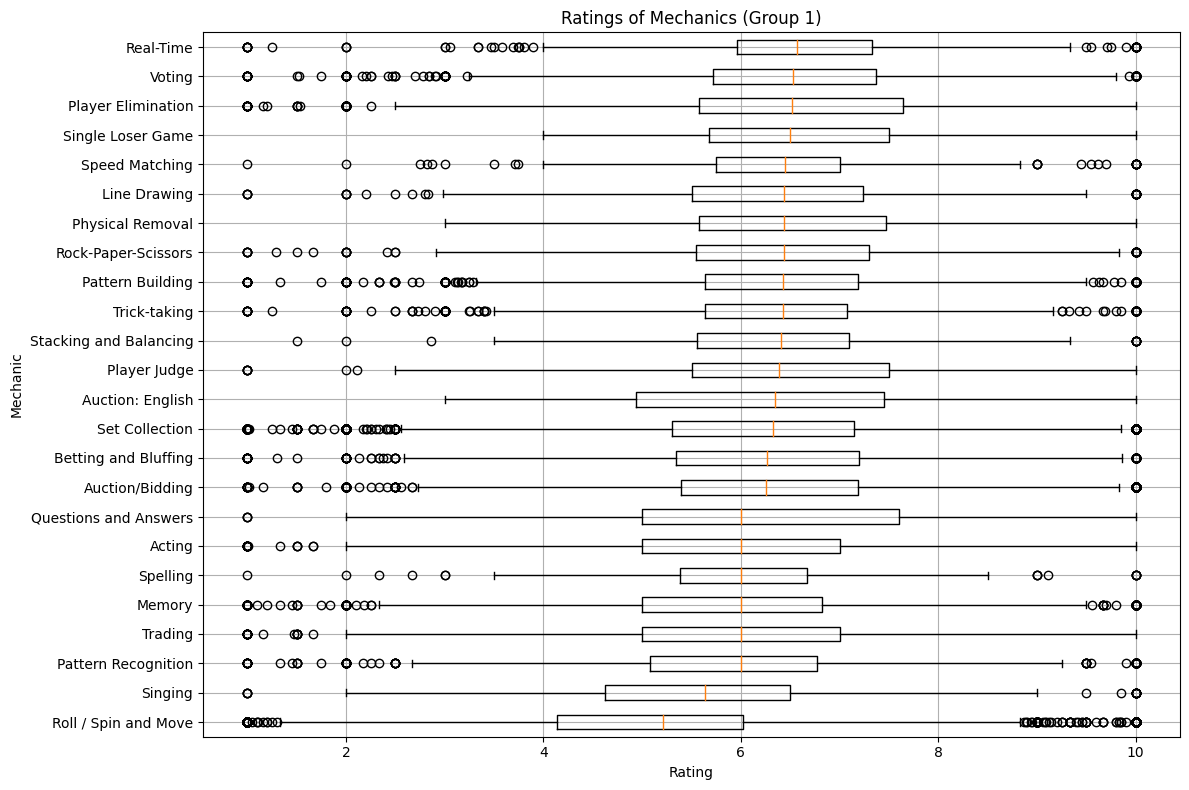

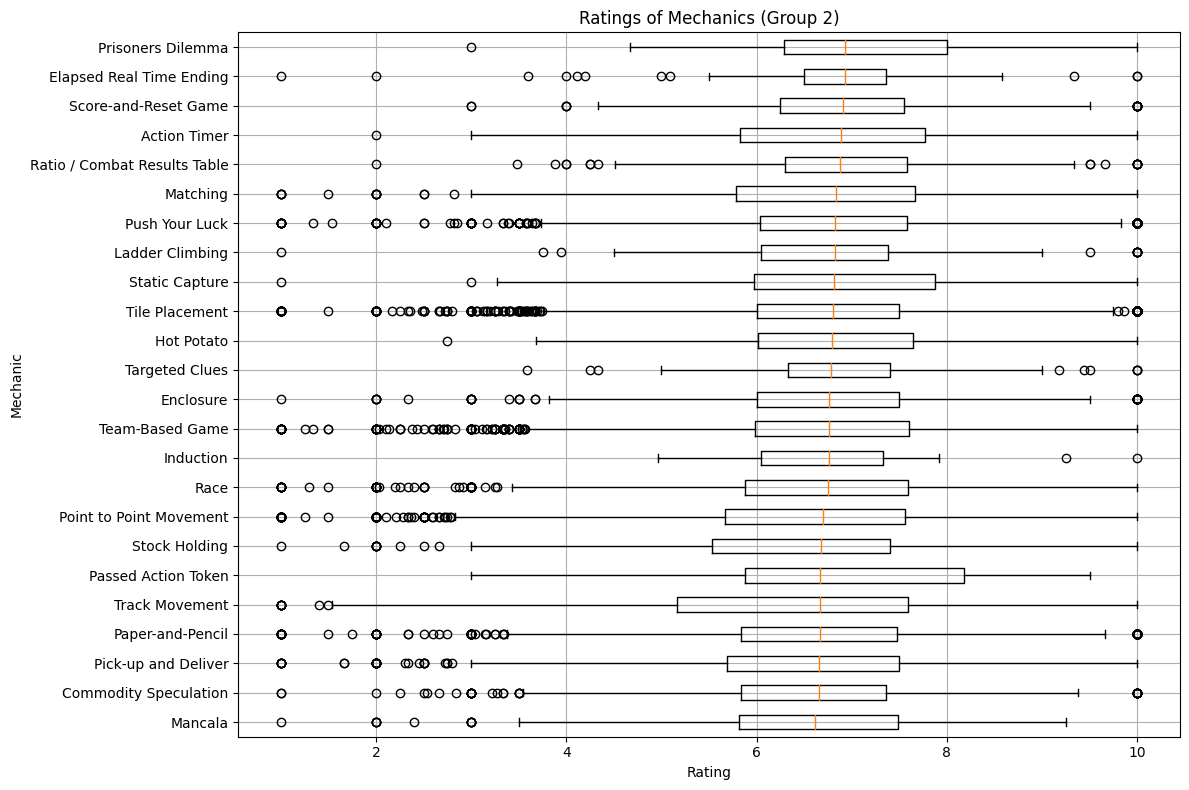

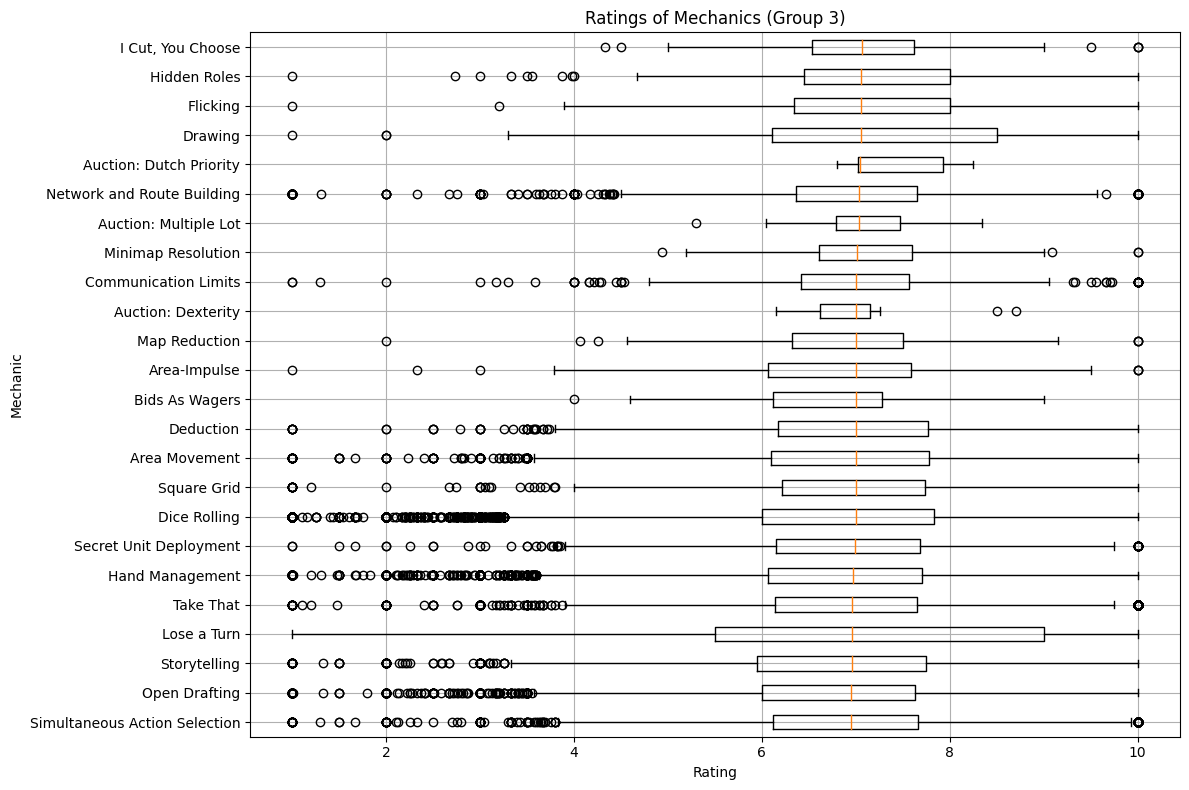

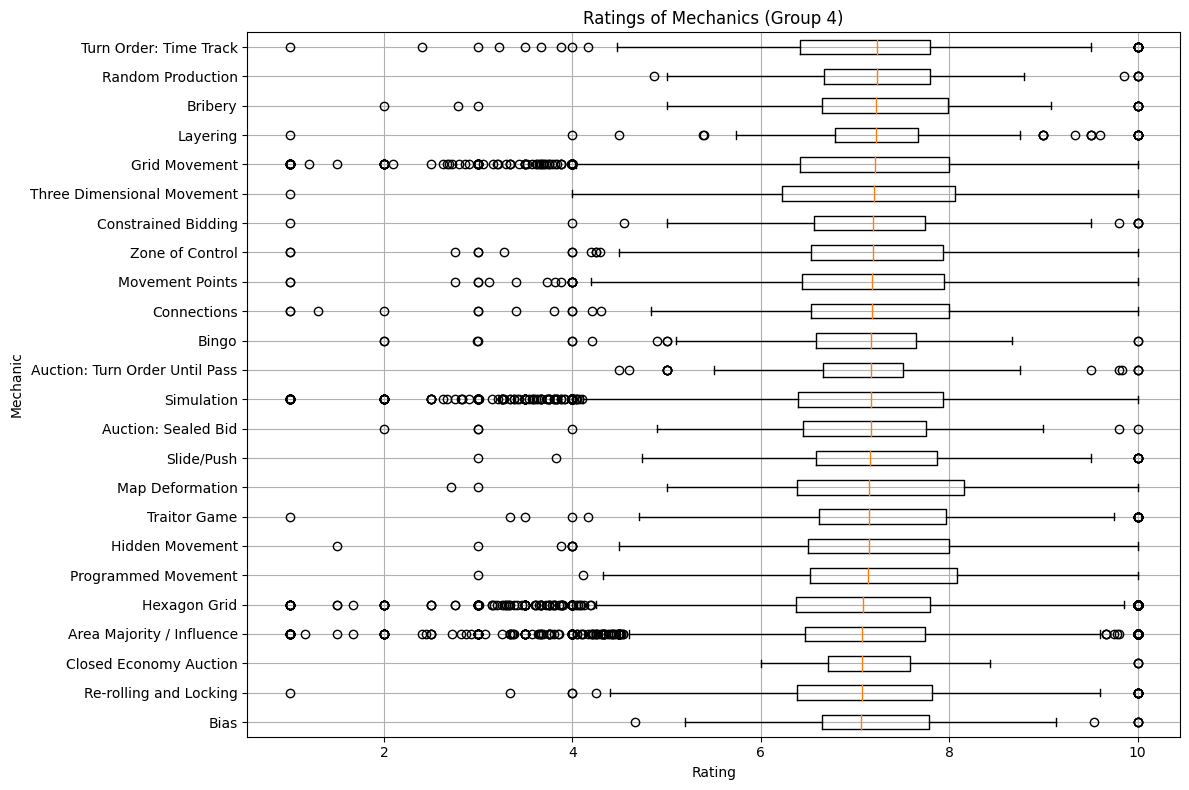

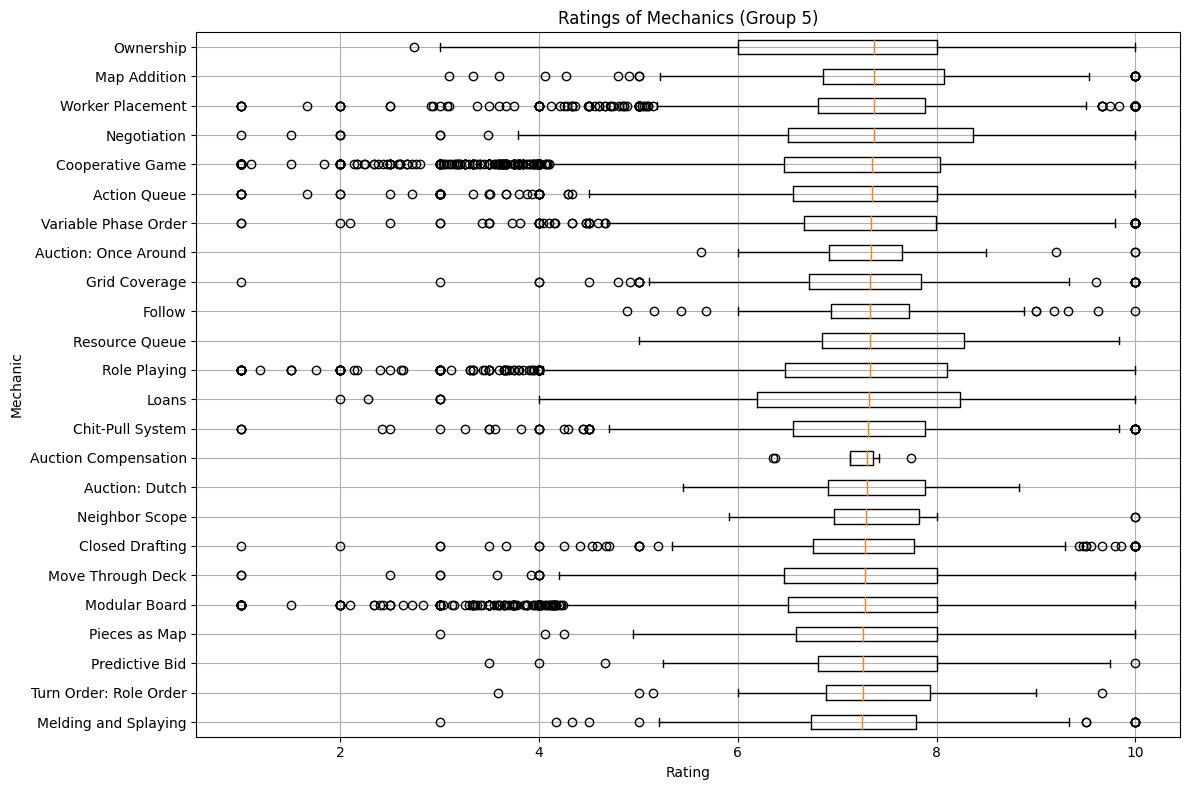

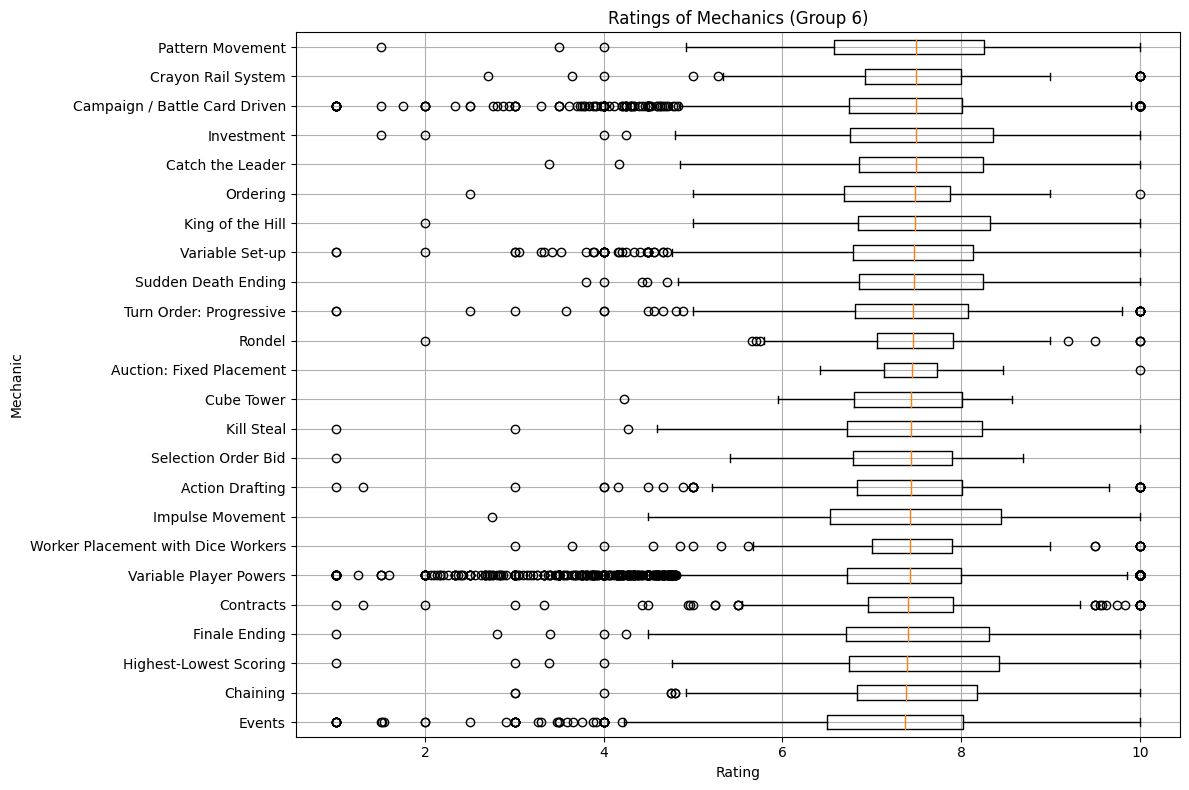

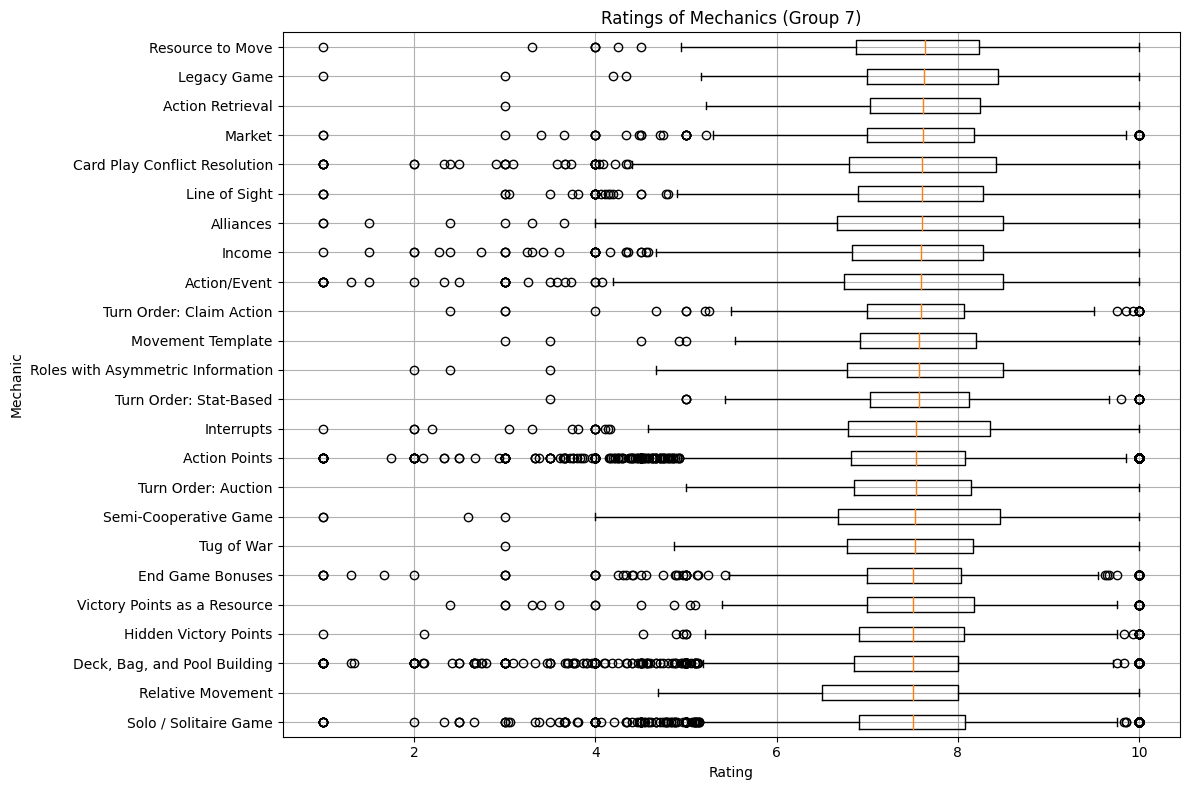

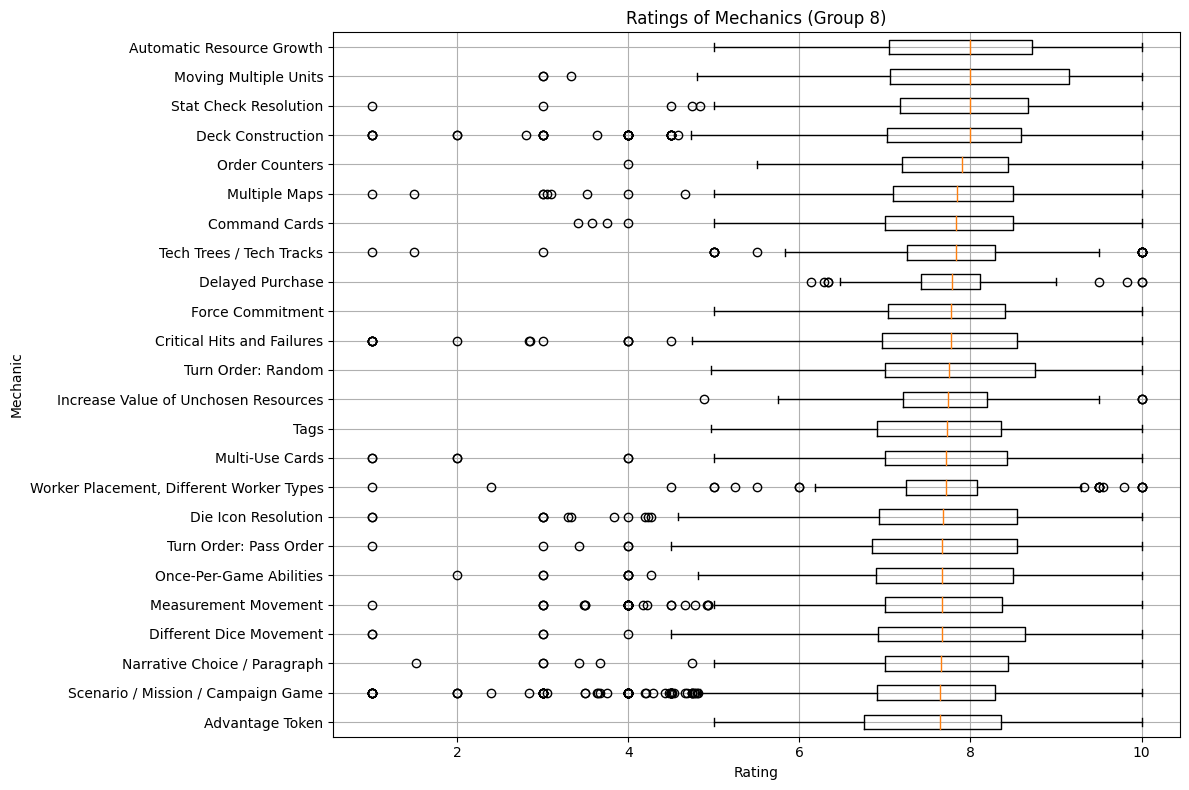

In [ ]:
# Draw Box Plots

# find median for each mechanic
medians = {mechanic: np.median(ratings) for mechanic, ratings in mechanicsDict.items()}

# sort the mechancis by median
sortedMechanics = sorted(mechanicsDict.keys(), key=lambda x: medians[x])

# split the mechanics into groups
mechanics_groups = [sortedMechanics[i:i + len(sortedMechanics)// 8] for i in range(0, len(sortedMechanics), len(sortedMechanics)// 8)]


# Draw and make box plots
for i, group in enumerate(mechanics_groups):
    plt.figure(figsize=(12, 8))
    box_data = [mechanicsDict[mechanic] for mechanic in group]
    plt.boxplot(box_data, labels=group, vert = False)

    # Add labels and title
    plt.xlabel('Rating')
    plt.ylabel('Mechanic')
    plt.title('Ratings of Mechanics (Group {})'.format(i+1))

    # Show plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Find average median of the ratings per mechanic

medians = [np.median(ratings) for ratings in mechanicsDict.values()]

print("mean of medain mechanic ratings (1-10):", np.mean(medians))

mean of medain mechanic ratings (1-10): 7.158688072916667


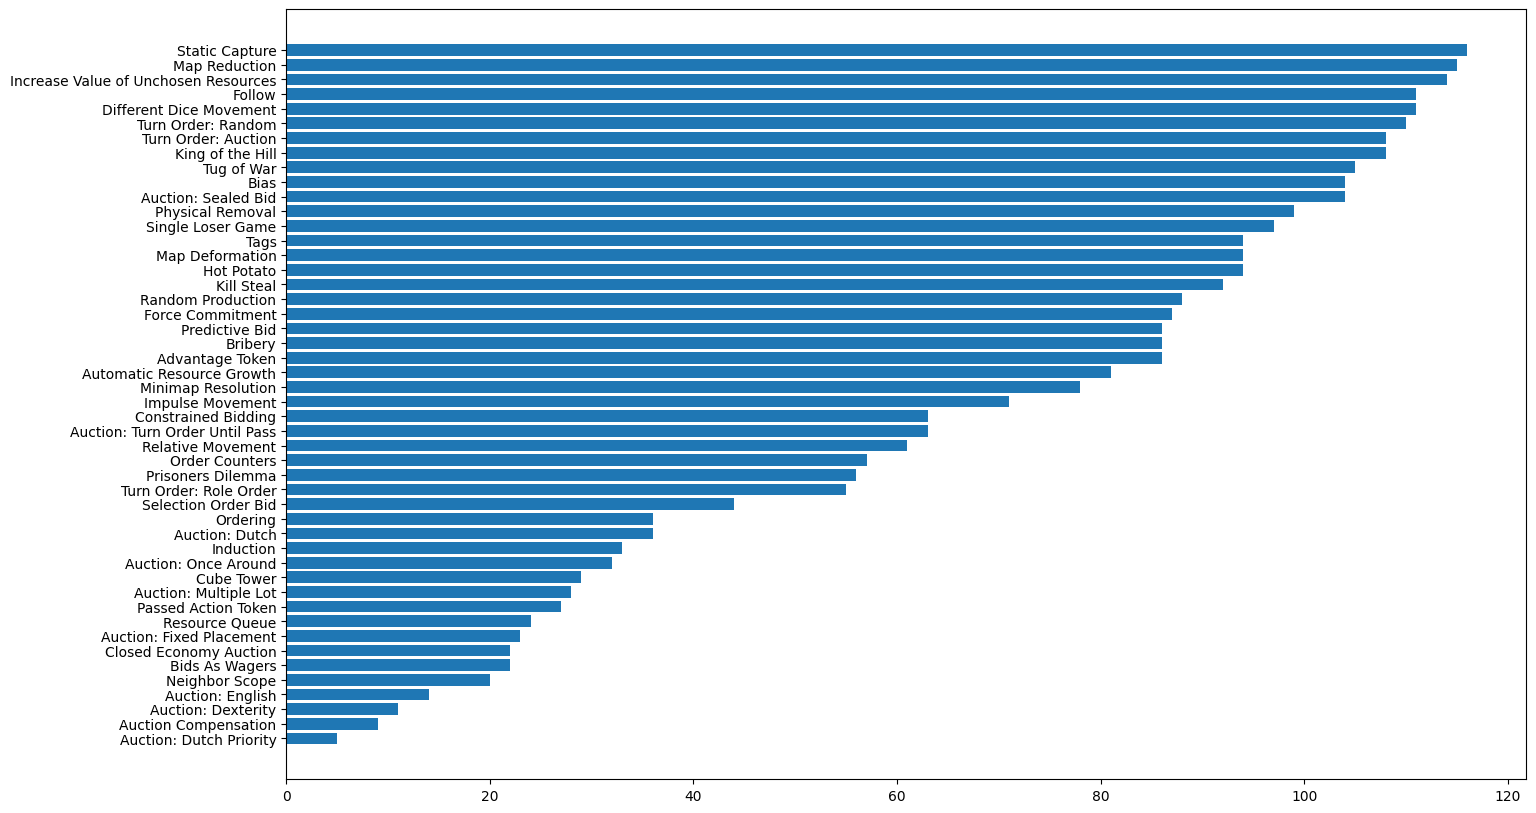

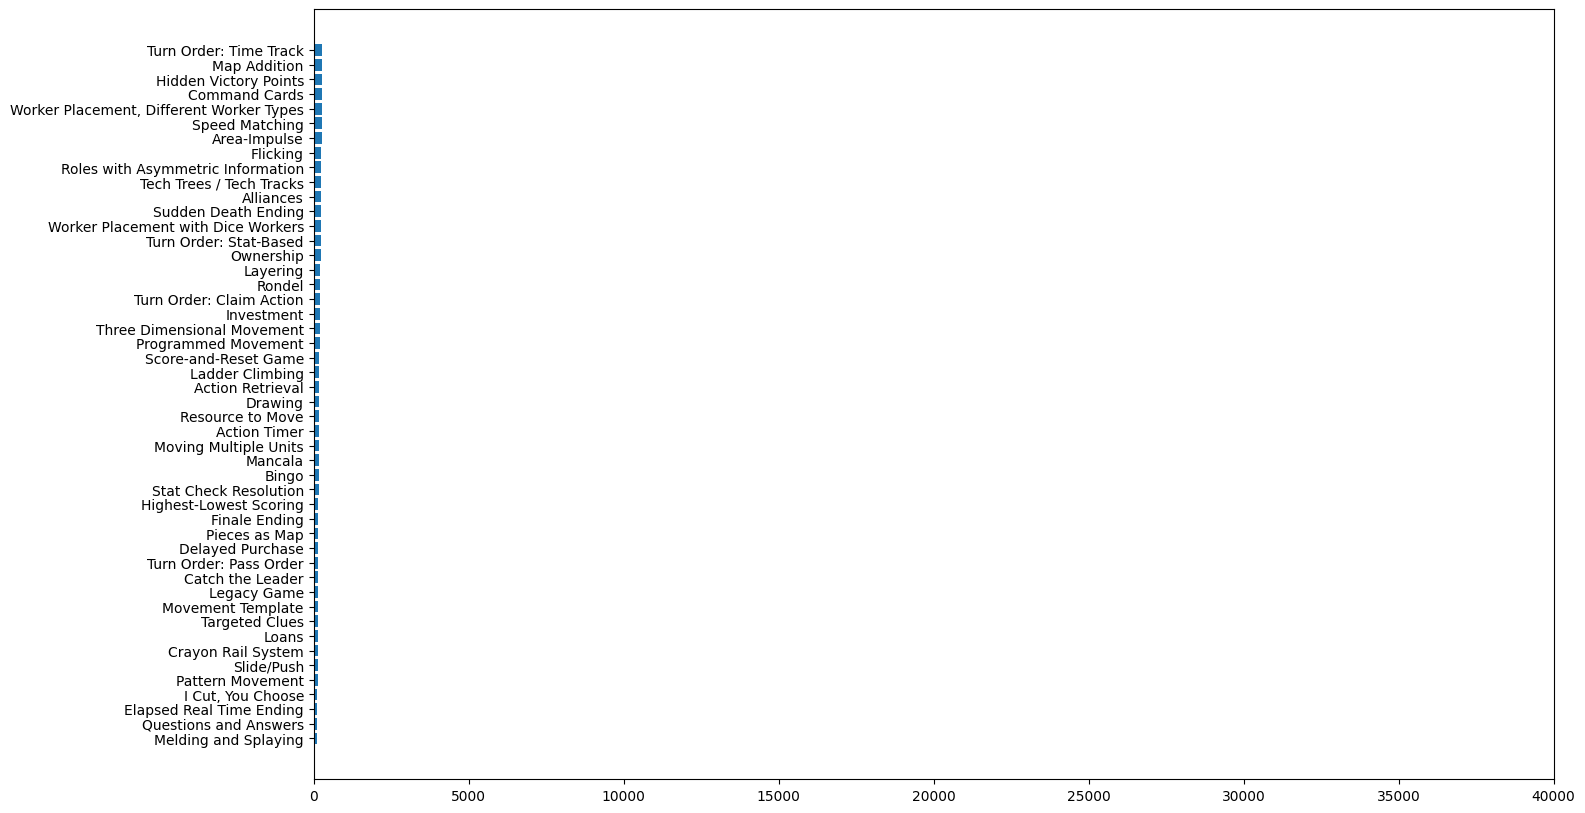

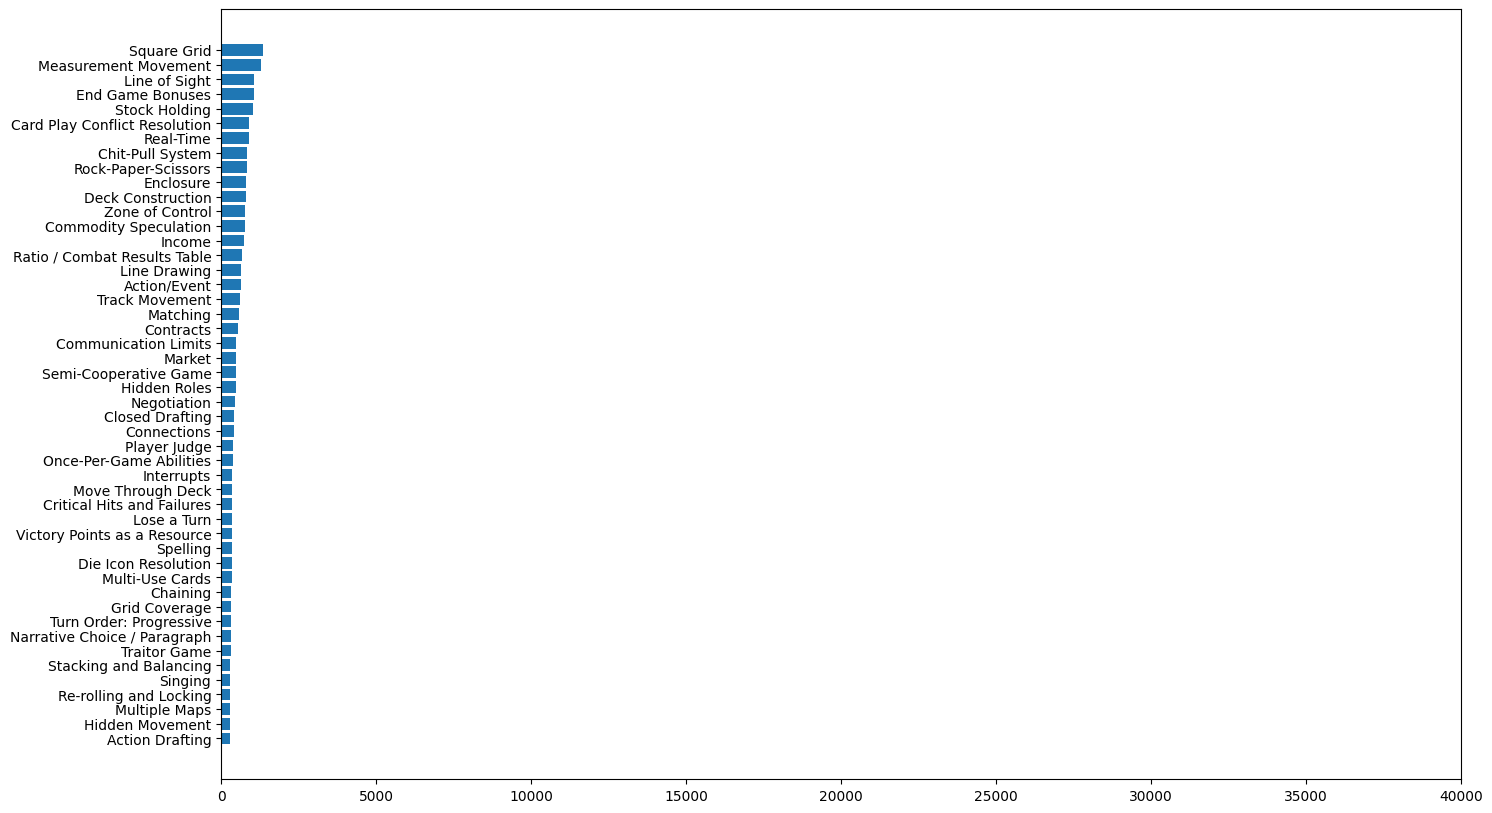

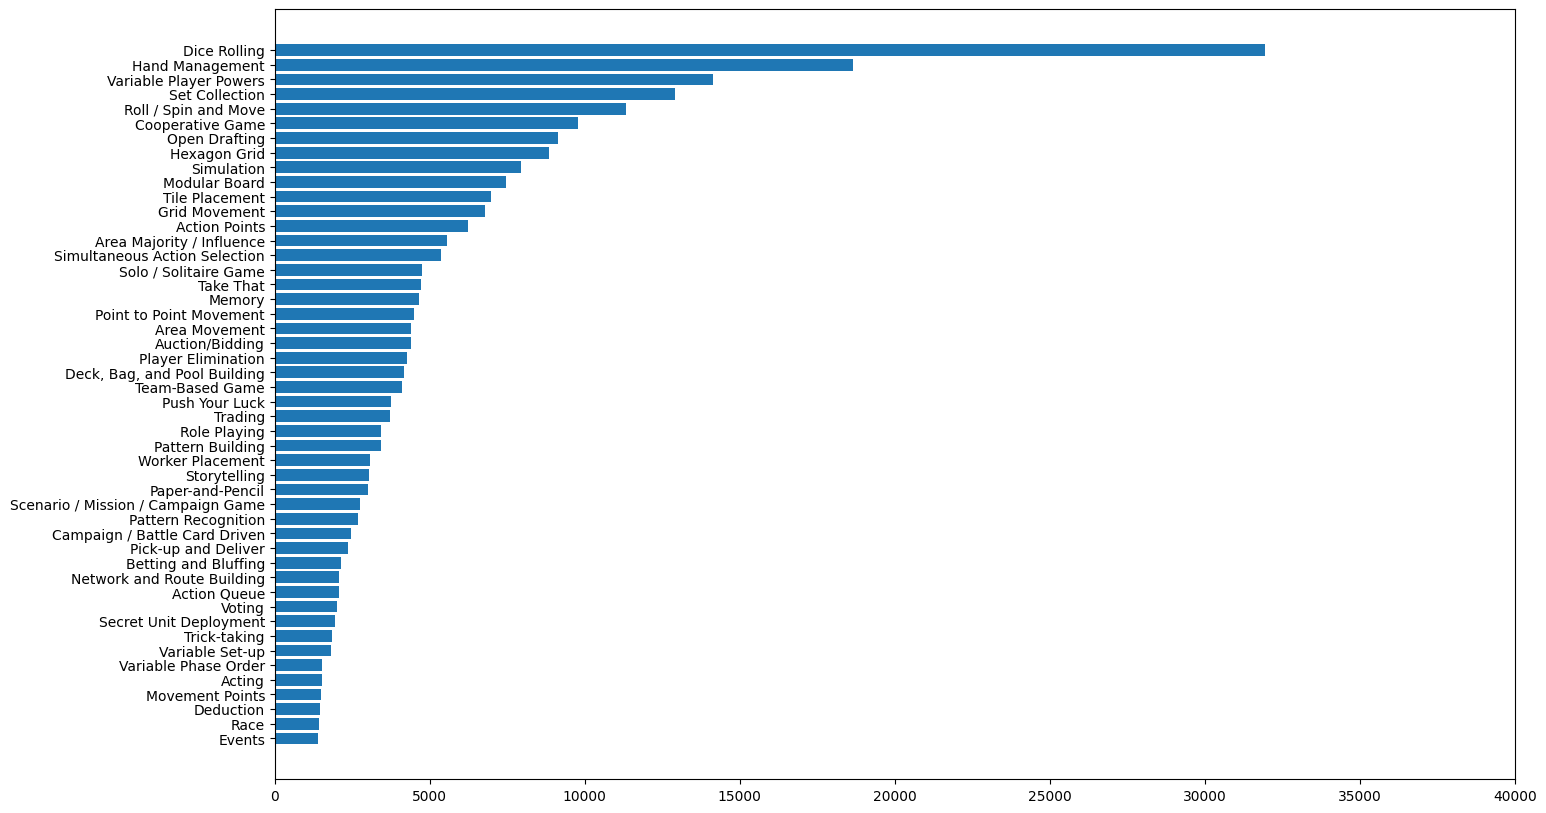

In [ ]:
# Create a historgram

mechanicsAmount = []
mechanicsList = list(mechanicsDict.keys())

# Get a number for all of the games per mechanic
for mechanic in mechanicsDict.keys():
  mechanicsAmount.append(len(mechanicsDict[mechanic]))

amountPerGraph = len(mechanicsAmount) / 4

# Zip the two lists together so we can sort them
zippedList = zip(mechanicsAmount, mechanicsList)
zippedList = sorted(zippedList)

mechanicsList = [j for i, j in zippedList]
mechanicsAmount = [i for i, j in zippedList]


plt.figure(figsize=(16, 10))
plt.barh(mechanicsList[:48], mechanicsAmount[:48])
plt.show()
plt.figure(figsize=(16, 10))
plt.barh(mechanicsList[48:96], mechanicsAmount[48:96])
plt.xlim([0,40000])
plt.show()
plt.figure(figsize=(16, 10))
plt.barh(mechanicsList[96:144], mechanicsAmount[96:144])
plt.xlim([0,40000])
plt.show()
plt.figure(figsize=(16, 10))
plt.barh(mechanicsList[144:], mechanicsAmount[144:])
plt.xlim([0,40000])
plt.show()


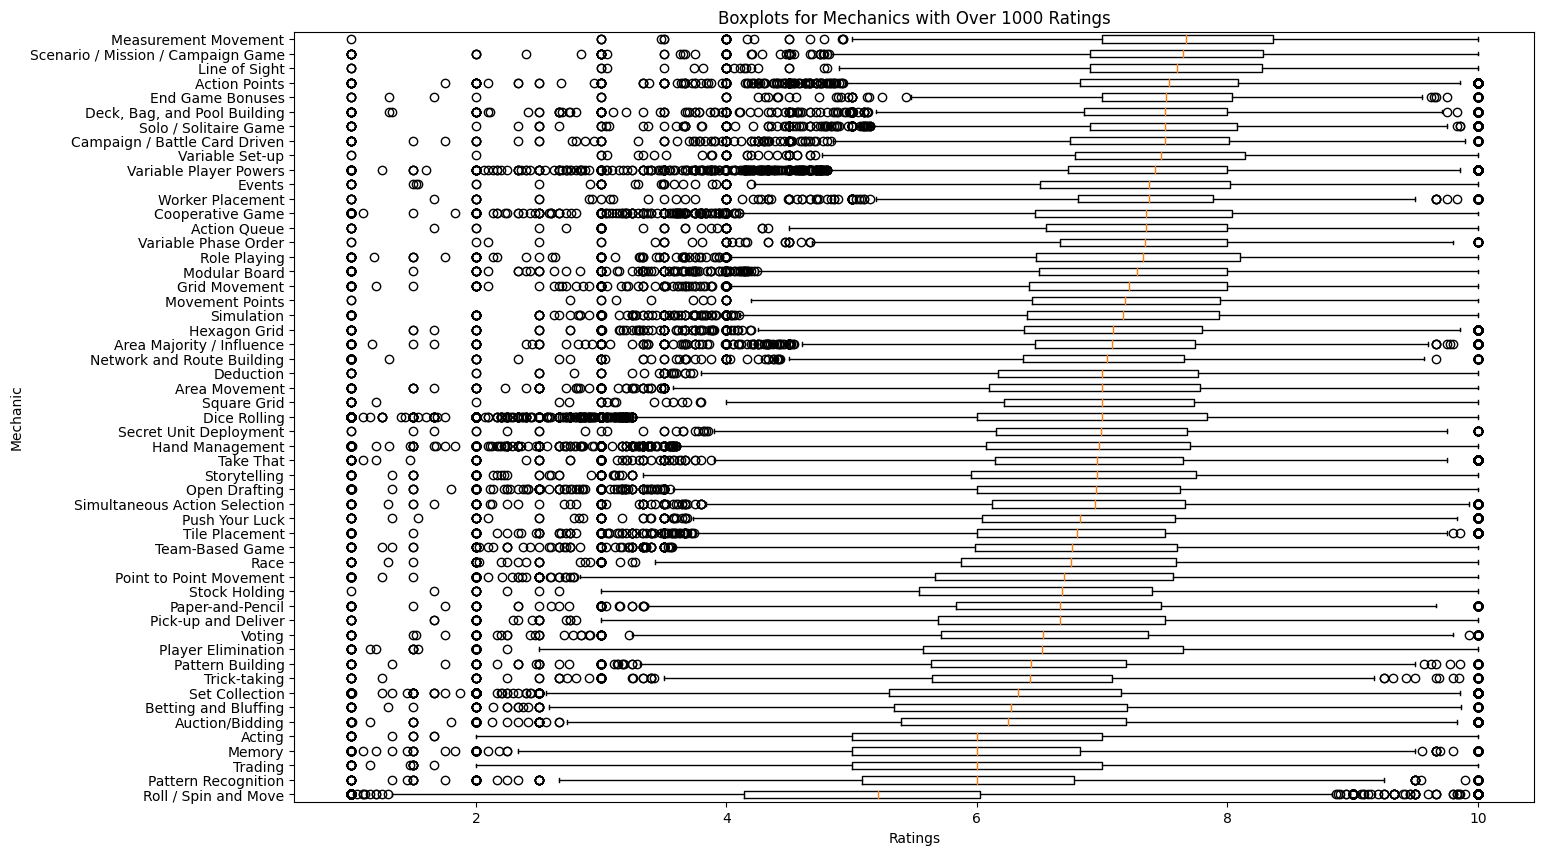

In [ ]:
filtered_sorted_mechanics = [mechanic for mechanic in sortedMechanics if len(mechanicsDict[mechanic]) > 1000]

plt.figure(figsize=(16, 10))
plt.boxplot([mechanicsDict[mechanic] for mechanic in filtered_sorted_mechanics], vert=False)
plt.yticks(range(1, len(filtered_sorted_mechanics) + 1), filtered_sorted_mechanics)
plt.ylabel('Mechanic')
plt.xlabel('Ratings')
plt.title('Boxplots for Mechanics with Over 1000 Ratings')
plt.show()


In [ ]:
medians2 = {key: np.median(values) for key, values in mechanicsDict.items()}

mean_median = np.mean([medians2[mechanic] for mechanic in filtered_sorted_mechanics])

mean_median

medians2['Roll / Spin and Move']

5.207585

# Top Games By Country

In [ ]:
import pandas as pd

# Read the CSV data into a DataFrame
data = pd.read_csv("random_10k_reviews.csv")

# Count the number of reviews for each country and sort them
country_review_counts = data['country'].value_counts().reset_index()
country_review_counts.columns = ['country', 'review_count']
sorted_countries = country_review_counts['country'].tolist()

# Merge the review counts with the original DataFrame
data_with_review_counts = pd.merge(data, country_review_counts, on='country')

# Group the data by both "country" and "name" columns, calculate average rating
average_ratings = data_with_review_counts.groupby(['country', 'name']).agg({'rating': 'mean', 'review_count': 'first'}).reset_index()

# Sort the countries based on the previously sorted review counts
average_ratings['country'] = pd.Categorical(average_ratings['country'], categories=sorted_countries, ordered=True)
average_ratings = average_ratings.sort_values(by=['country', 'rating', 'review_count'], ascending=[True, False, False])

# Filter out games with less than 3 reviews in a country
average_ratings_filtered = average_ratings[average_ratings['review_count'] >= 3]

# Define a function to select top N rows for each group
def top_n(df, n=10):
    return df.head(n)

# Group the sorted and filtered DataFrame by "country" and select the top 10 rated games for each country
top_10_games_by_country = average_ratings_filtered.groupby('country', group_keys=False).apply(top_n, n=10)

# Save the top 10 rated games for each country to a CSV file
top_10_games_by_country.to_csv("top_10_games_by_country.csv", index=False)

print("Top 10 rated games for each country with at least 3 reviews have been saved to top_10_games_by_country.csv")

# Predictive models for determining rating based on review comments

In [28]:
# TF-IDF (Term Frequency-Inverse Document Frequency)/Ridge

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Loading/Preparing the data
file_path = 'random_10k_reviews.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['comment']) # Remove rows where 'comment' is NaN as we cannot use these for prediction
X = data['comment']
y = data['rating']

# Splitting the data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),  # Converting the text into TF-IDF features
    ('model', Ridge())  # Ridge regression model
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluating the model using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R Squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')

MSE: 2.8053259454129384
RMSE: 1.6749107275950377
R² Score: 0.14634085877042147


In [27]:
# TF-IDF (Term Frequency-Inverse Document Frequency)/RandomForestRegressor

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

# Loading/Preparing the data
file_path = 'random_10k_reviews.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['comment']) # Remove rows where 'comment' is NaN as we cannot use these for prediction
X = data['comment']
y = data['rating']

# Splitting the data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),  # Converting the text into TF-IDF features
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest model
])


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluating the model using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R Squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')

MSE: 3.032271380523441
RMSE: 1.7413418333352704
R² Score: 0.07728148776963484


In [26]:
# Word2Vec/Ridge predictive model to determine rating based on reviews

import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from nltk import word_tokenize
import numpy as np
import nltk

# Loading/Preparing the data
nltk.download('punkt')
file_path = 'random_10k_reviews.csv'
data = pd.read_csv(file_path)
data = data.dropna(subset=['comment'])
data['tokenized_comments'] = data['comment'].apply(lambda x: word_tokenize(x.lower())) # Tokenize the comments for Word2Vec training

# Training a Word2Vec model
w2v_model = Word2Vec(sentences=data['tokenized_comments'], vector_size=100, window=5, min_count=1, workers=4)

# Defining a helper function to convert the comments into an average Word2Vec vector
def averageVector(comment):
    words = word_tokenize(comment.lower())
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]

    if len(word_vectors) == 0:
        return np.zeros(w2v_model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

# Converting the comments into average vectors
X = data['comment'].apply(averageVector).tolist()
y = data['rating'].values

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using a Ridge regression model
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluating the model using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R Squared
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R² Score: {r2}')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


MSE: 3.251135775539416
RMSE: 1.8030906176727268
R² Score: 0.010681172822073037
